In [17]:
import pandas as pd
%matplotlib inline 
import datetime
import matplotlib.pyplot as plt
from scipy import stats  
import seaborn as sns
from sklearn import preprocessing

In [62]:
df = pd.read_csv('twitter_june3.csv', encoding = "UTF-8",parse_dates =['created_time','created_date'])
len(df)

4399

In [66]:
len(df['created_date'].unique())

83

In [18]:
df = pd.read_csv('twitter_june3.csv', encoding = "UTF-8",parse_dates =['created_time','created_date'])
df = df.loc[df['created_date'] <= datetime.date(2016, 6, 1)]

In [61]:
len(df)

4103

In [71]:
import math
df['retweet_count_log'] = df['retweet_count'].map(lambda x: math.log(x) if x != 0 else 0)
df['favorite_count_log'] = df['favorite_count'].map(lambda x: math.log(x) if x != 0 else 0)

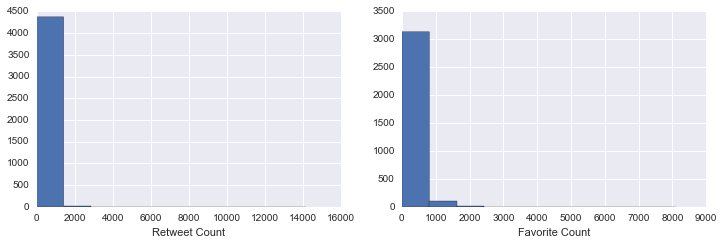

In [73]:
fig, axs = plt.subplots(1,2,figsize=(12,3.5))
p = df['retweet_count'].hist(ax=axs[0])
p.set_xlabel("Retweet Count")
p = df[df['retweet']=='No']['favorite_count'].hist(ax=axs[1])
p.set_xlabel("Favorite Count")
p.get_figure().savefig("count_distribution_beforelog.png")

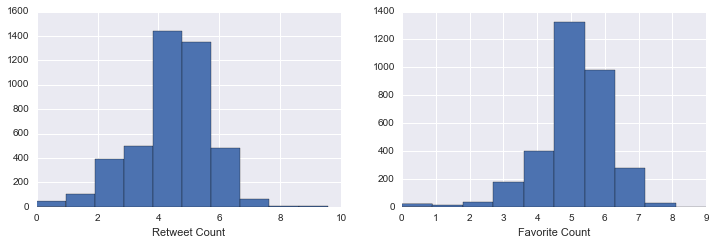

In [74]:
fig, axs = plt.subplots(1,2,figsize=(12,3.5))
p = df['retweet_count_log'].hist(ax=axs[0])
p.set_xlabel("Retweet Count")
p = df[df['retweet']=='No']['favorite_count_log'].hist(ax=axs[1])
p.set_xlabel("Favorite Count")
p.get_figure().savefig("count_distribution_afterlog.png")

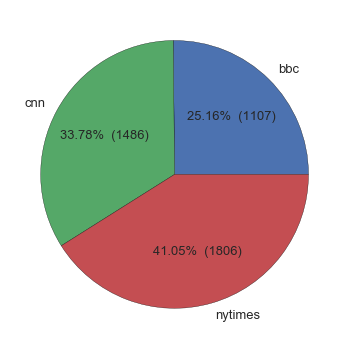

In [117]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
p = df.groupby('user')['text'].count().plot.pie(autopct=make_autopct(df.groupby('user')['text'].count()), fontsize=13, figsize=(6, 6))
p.set_ylabel("")
p.get_figure().savefig("user_piechart.png")

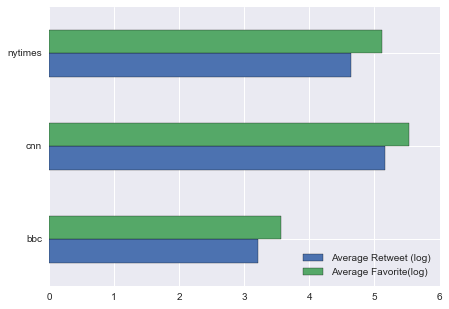

In [105]:
retweet_user = df.groupby('user')['retweet_count_log'].mean()
favorite_user = df[df['retweet']=='No'].groupby('user')['favorite_count_log'].mean()
p = pd.concat([retweet_user, favorite_user], axis=1).plot.barh(figsize=(7,5))
p.set_ylabel("")
lines, labels = p.get_legend_handles_labels()
p.legend(lines[:2], ["Average Retweet (log)", "Average Favorite(log)"], loc='best')
p.get_figure().savefig("user_retweet_favorite.png")

In [135]:
f_val, p_val = stats.f_oneway(*[ df[df['user']==h]['retweet_count_log'] for h in sorted(df['user'].unique())])
print("P value for User (retweet): " + str(p_val))
f_val, p_val = stats.f_oneway(*[ df[(df['retweet']=='No')&(df['user']==h)]['favorite_count_log'] for h in sorted(df['user'].unique())])
print("P value for User (favorite): " + str(p_val))

P value for User (retweet): 0.0
P value for User (favorite): 6.40309598691e-270


In [107]:
retweet_bbc = df[df['user']=='bbc']['retweet_count_log'].reshape(-1, 1)
retweet_bbc_scaler = preprocessing.MinMaxScaler()
df.loc[df['user']=='bbc','retweet_count_scaled'] = retweet_bbc_scaler.fit_transform(retweet_bbc)

retweet_cnn = df[df['user']=='cnn']['retweet_count_log'].reshape(-1, 1)
retweet_cnn_scaler = preprocessing.MinMaxScaler()
df.loc[df['user']=='cnn','retweet_count_scaled'] = retweet_cnn_scaler.fit_transform(retweet_cnn)

retweet_nytimes = df[df['user']=='nytimes']['retweet_count_log'].reshape(-1, 1)
retweet_nytimes_scaler = preprocessing.MinMaxScaler()
df.loc[df['user']=='nytimes','retweet_count_scaled'] = retweet_bbc_scaler.fit_transform(retweet_nytimes)

favorite_bbc = df[df['user']=='bbc']['favorite_count_log'].reshape(-1, 1)
favorite_bbc_scaler = preprocessing.MinMaxScaler()
df.loc[df['user']=='bbc','favorite_count_scaled'] = favorite_bbc_scaler.fit_transform(favorite_bbc)

favorite_cnn = df[df['user']=='cnn']['favorite_count_log'].reshape(-1, 1)
favorite_cnn_scaler = preprocessing.MinMaxScaler()
df.loc[df['user']=='cnn','favorite_count_scaled'] = favorite_cnn_scaler.fit_transform(favorite_cnn)

favorite_nytimes = df[df['user']=='nytimes']['favorite_count_log'].reshape(-1, 1)
favorite_nytimes_scaler = preprocessing.MinMaxScaler()
df.loc[df['user']=='nytimes','favorite_count_scaled'] = favorite_bbc_scaler.fit_transform(favorite_nytimes)

In [108]:
remove_retweet_weekday_trend = 1/df.groupby('created_weekday')['retweet_count_scaled'].mean()
remove_favorite_weekday_trend = 1/df[df['retweet']=='No'].groupby('created_weekday')['favorite_count_scaled'].mean()
df['retweet_count_detrend_weekday']= df.apply(lambda x: x['retweet_count_scaled'] * remove_retweet_weekday_trend[x['created_weekday']], axis=1)
df['favorite_count_detrend_weekday']= df.apply(lambda x: x['favorite_count_scaled'] * remove_favorite_weekday_trend[x['created_weekday']], axis=1)

remove_retweet_weekdayhour_trend = 1/df.groupby('created_hour')['retweet_count_detrend_weekday'].mean()
remove_favorite_weekdayhour_trend = df[df['retweet']=='No'].groupby('created_hour')['favorite_count_detrend_weekday'].mean()
df['retweet_count_detrend_weekdayhour']= df.apply(lambda x: x['retweet_count_detrend_weekday'] * remove_retweet_weekdayhour_trend[x['created_hour']], axis=1)
df['favorite_count_detrend_weekdayhour']= df.apply(lambda x: x['favorite_count_detrend_weekday'] * remove_favorite_weekdayhour_trend[x['created_hour']], axis=1)

In [133]:
detrend_weekday_df = pd.concat([pd.DataFrame(remove_retweet_weekday_trend),pd.DataFrame(remove_favorite_weekday_trend)],axis=1).reset_index()
detrend_weekday_df.rename(columns={'created_weekday':'weekday','retweet_count_scaled':'retweet','favorite_count_scaled':'favorite'})

,weekday,retweet,favorite
0,1,2.117728,1.551677
1,2,2.172123,1.592497
2,3,2.096129,1.597359
3,4,2.102593,1.599739
4,5,2.147365,1.594866
5,6,2.282804,1.595322
6,7,2.152464,1.506219


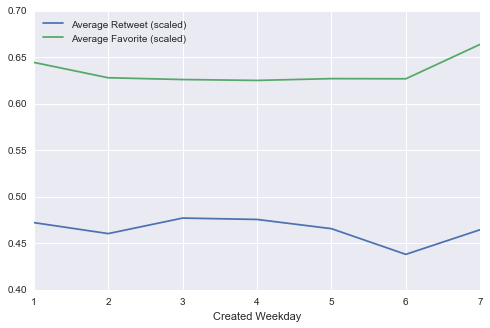

In [123]:
temp = df.groupby('created_weekday')['retweet_count_scaled'].mean()
p = temp.plot(figsize=(8,5))
temp = df[df['retweet']=='No'].groupby('created_weekday')['favorite_count_scaled'].mean()
p = temp.plot()
p.set_xlabel("Created Weekday")
lines, labels = p.get_legend_handles_labels()
p.legend(lines[:2], ["Average Retweet (scaled)", "Average Favorite (scaled)"], loc='best')
p.get_figure().savefig("weekday_line.png")

In [137]:
f_val, p_val = stats.f_oneway(*[ df[df['created_weekday']==h]['retweet_count_scaled'] for h in sorted(df['created_weekday'].unique())])
print("P value for Weekday (retweet): " + str(p_val))
f_val, p_val = stats.f_oneway(*[ df[(df['retweet']=='No')&(df['created_weekday']==h)]['favorite_count_scaled'] for h in sorted(df['created_weekday'].unique())])
print("P value for Weekday (favorite): " + str(p_val))

P value for Weekday (retweet): 0.000430164278737
P value for Weekday (favorite): 1.31304704915e-05


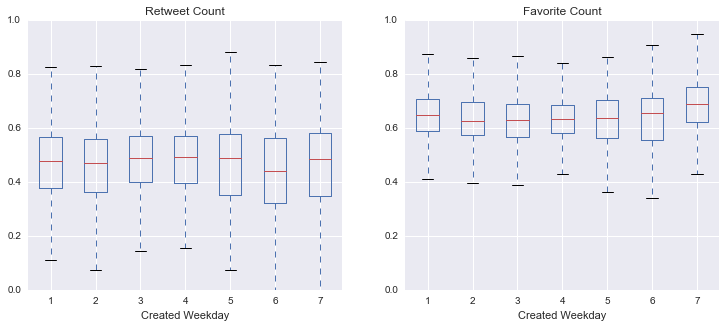

In [139]:
fig, axs = plt.subplots(1,2,figsize=(12,5))

p = df.boxplot(column=['retweet_count_scaled'], by=['created_weekday'], ax=axs[0])
p.set_xlabel("Created Weekday")
p.get_figure().suptitle("")
p.set_title('Retweet Count')
p.get_figure().savefig("output.png")

p = df[df['retweet']=='No'].boxplot(column=['favorite_count_scaled'], by=['created_weekday'], ax=axs[1])
p.set_xlabel("Created Weekday")
p.get_figure().suptitle("")
p.set_title('Favorite Count')
p.get_figure().savefig("output.png")

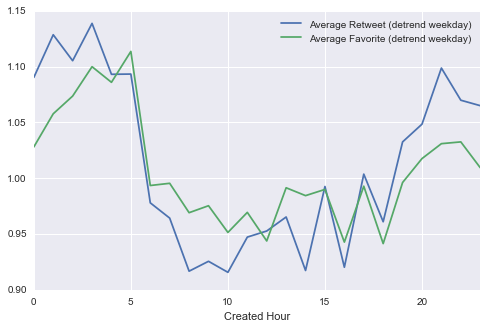

In [210]:
temp = df.groupby('created_hour')['retweet_count_detrend_weekday'].mean()
p = temp.plot(figsize=(8,5))
temp = df[df['retweet']=='No'].groupby('created_hour')['favorite_count_detrend_weekday'].mean()
p = temp.plot()
p.set_xlabel("Created Hour")
lines, labels = p.get_legend_handles_labels()
p.legend(lines[:2], ["Average Retweet (detrend weekday)", "Average Favorite (detrend weekday)"], loc='best')
p.get_figure().savefig("hour_line.png")

In [216]:
f_val, p_val = stats.f_oneway(*[ df[df['created_hour']==h]['retweet_count_detrend_weekday'] for h in sorted(df['created_hour'].unique())])
print("P value for Hour (retweet): " + str(p_val))
f_val, p_val = stats.f_oneway(*[ df[(df['retweet']=='No')&(df['created_hour']==h)]['favorite_count_detrend_weekday'] for h in sorted(df['created_hour'].unique())])
print("P value for Hour (favorite): " + str(p_val))

P value for Hour (retweet): 5.78241232344e-36
P value for Hour (favorite): 1.30106839836e-28


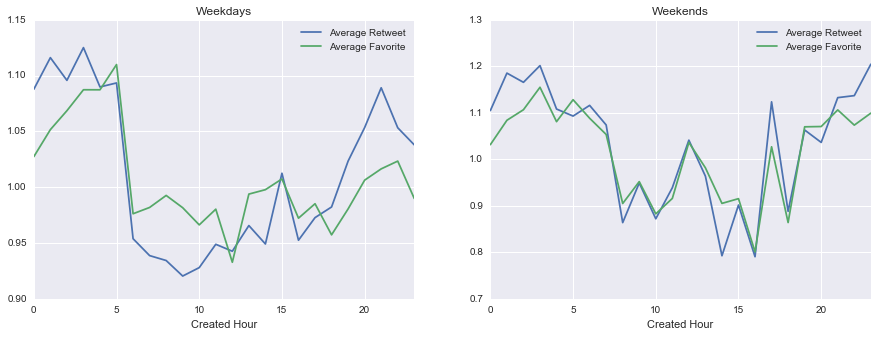

In [215]:
fig, axs = plt.subplots(1,2,figsize=(15,5))

temp = df[df['created_weekday'].isin([1,2,3,4,5])].groupby('created_hour')['retweet_count_detrend_weekday'].mean()
p = temp.plot(ax=axs[0])
temp = df[(df['created_weekday'].isin([1,2,3,4,5]))&(df['retweet']=='No')].groupby('created_hour')['favorite_count_detrend_weekday'].mean()
p = temp.plot(ax=axs[0])
p.set_xlabel("Created Hour")
p.set_title("Weekdays")
lines, labels = p.get_legend_handles_labels()
p.legend(lines[:2], ["Average Retweet", "Average Favorite"], loc='best')
p.get_figure().savefig("hour_line.png")

temp = df[df['created_weekday'].isin([6,7])].groupby('created_hour')['retweet_count_detrend_weekday'].mean()
p = temp.plot(ax=axs[1])
temp = df[(df['created_weekday'].isin([6,7]))&(df['retweet']=='No')].groupby('created_hour')['favorite_count_detrend_weekday'].mean()
p = temp.plot(ax=axs[1])
p.set_xlabel("Created Hour")
p.set_title("Weekends")
lines, labels = p.get_legend_handles_labels()
p.legend(lines[:2], ["Average Retweet", "Average Favorite"], loc='best')
p.get_figure().savefig("hour_line_weekday_weekend.png")

In [217]:
f_val, p_val = stats.f_oneway(*[ df[(df['created_weekday'].isin([1,2,3,4,5]))&
                                    (df['created_hour']==h)]['retweet_count_detrend_weekday'] for h in sorted(df['created_hour'].unique())])
print("P value for Hour - Weekday (retweet): " + str(p_val))
f_val, p_val = stats.f_oneway(*[ df[(df['created_weekday'].isin([1,2,3,4,5]))&
                                    (df['retweet']=='No')&
                                    (df['created_hour']==h)]['favorite_count_detrend_weekday'] for h in sorted(df['created_hour'].unique())])
print("P value for Hour - Weekday (favorite): " + str(p_val))

f_val, p_val = stats.f_oneway(*[ df[(df['created_weekday'].isin([6,7]))&
                                    (df['created_hour']==h)]['retweet_count_detrend_weekday'] for h in sorted(df['created_hour'].unique())])
print("P value for Hour - Weekend (retweet): " + str(p_val))
f_val, p_val = stats.f_oneway(*[ df[(df['created_weekday'].isin([6,7]))&
                                    (df['retweet']=='No')&
                                    (df['created_hour']==h)]['favorite_count_detrend_weekday'] for h in sorted(df['created_hour'].unique())])
print("P value for Hour - Weekend (favorite): " + str(p_val))

P value for Hour - Weekday (retweet): 3.74557737486e-22
P value for Hour - Weekday (favorite): 7.4768669676e-18
P value for Hour - Weekend (retweet): 4.68188050675e-14
P value for Hour - Weekend (favorite): 1.41968355422e-14


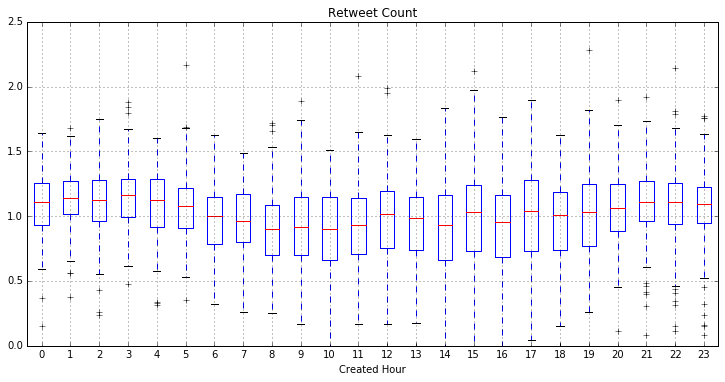

In [54]:
p = df.boxplot(column=['retweet_count_detrend_weekday'], by=['created_hour'], figsize=(12,6),)
p.set_xlabel("Created Hour")
p.get_figure().suptitle("")
p.set_title('Retweet Count')
p.get_figure().savefig("output.png")

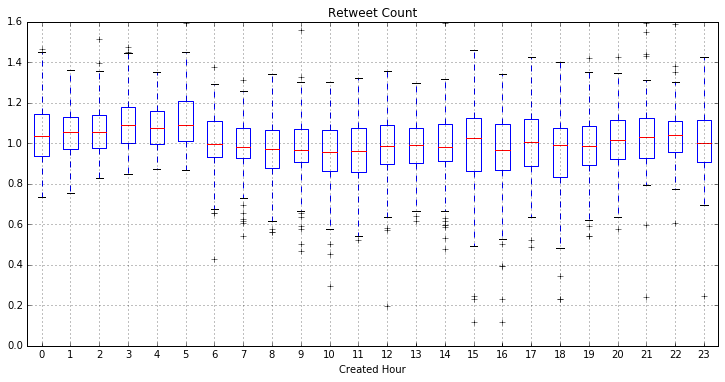

In [52]:
p = df[df['retweet']=='No'].boxplot(column=['favorite_count_detrend_weekday'], by=['created_hour'], figsize=(12,6),)
p.set_xlabel("Created Hour")
p.get_figure().suptitle("")
p.set_title('Favorite Count')
p.get_figure().savefig("output.png")

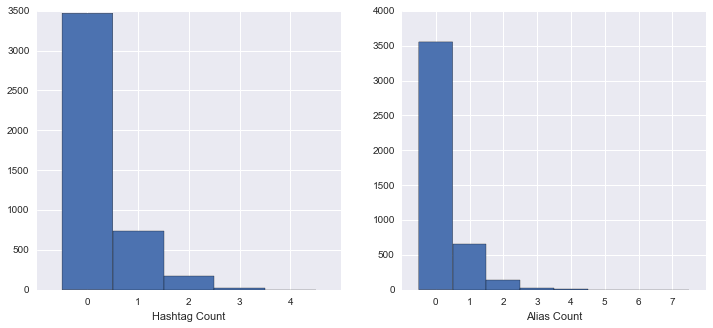

In [111]:
fig, axs = plt.subplots(1,2,figsize=(12,5))

p = df['hashtag_count'].hist(ax=axs[0], bins=(pd.np.arange(6) - 0.5))
p.set_xticks(df['hashtag_count'].unique())
p.set_xlabel("Hashtag Count")

p = df['aliastag_count'].hist(ax=axs[1],bins=(pd.np.arange(9) - 0.5))
p.set_xticks(df['aliastag_count'].unique())
p.set_xlabel("Alias Count")

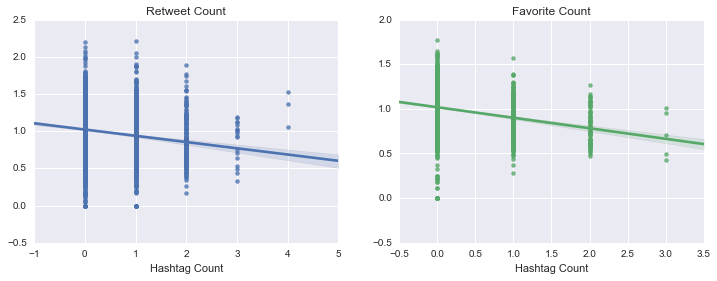

In [156]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
p = sns.regplot(x="hashtag_count", y="retweet_count_detrend_weekdayhour", data=df, ax=axs[0])
p.set_xlabel("Hashtag Count")
p.set_ylabel("")
p.set_title('Retweet Count')

p = sns.regplot(x="hashtag_count", y="favorite_count_detrend_weekdayhour", data=df[(df['retweet']=='No')&(df['hashtag_count']!=4)], ax=axs[1])
p.set_xlabel("Hashtag Count")
p.set_ylabel("")
p.set_title('Favorite Count')
p.get_figure().savefig("hashtag_scatter.png")

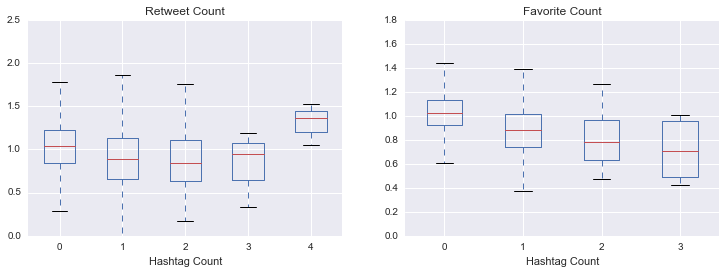

In [157]:
fig, axs = plt.subplots(1,2,figsize=(12,4))

p = df.boxplot(column=['retweet_count_detrend_weekdayhour'], by=['hashtag_count'], ax=axs[0])
p.set_xlabel("Hashtag Count")
p.get_figure().suptitle("")
p.set_title('Retweet Count')

p = df[(df['retweet']=='No')&(df['hashtag_count']!=4)].boxplot(column=['favorite_count_detrend_weekdayhour'], by=['hashtag_count'], ax=axs[1])
p.set_xlabel("Hashtag Count")
p.get_figure().suptitle("")
p.set_title('Favorite Count')
p.get_figure().savefig("hashtag_box.png")

In [167]:
coefficient, p_val = stats.pearsonr(df['retweet_count_detrend_weekdayhour'],df['hashtag_count'])
pearson_retweet = ["Retweet", 'Pearson', coefficient, p_val]
coefficient, p_val = stats.pearsonr(df[(df['retweet']=='No')&(df['hashtag_count']!=4)]['favorite_count_detrend_weekdayhour'],
                                    df[(df['retweet']=='No')&(df['hashtag_count']!=4)]['hashtag_count'])
pearson_favorite = ["Favorite", 'Pearson', coefficient, p_val]

coefficient, p_val = stats.spearmanr(df['retweet_count_detrend_weekdayhour'],df['hashtag_count'])
spearman_retweet = ["Retweet", 'Spearman', coefficient, p_val]
coefficient, p_val = stats.spearmanr(df[(df['retweet']=='No')&(df['hashtag_count']!=4)]['favorite_count_detrend_weekdayhour'],
                                    df[(df['retweet']=='No')&(df['hashtag_count']!=4)]['hashtag_count'])
spearman_favorite = ["Favorite", 'Spearman', coefficient, p_val]

coefficient, p_val = stats.kendalltau(df['retweet_count_detrend_weekdayhour'],df['hashtag_count'])
kendall_retweet = ["Retweet", 'Kendall', coefficient, p_val]
coefficient, p_val = stats.kendalltau(df[(df['retweet']=='No')&(df['hashtag_count']!=4)]['favorite_count_detrend_weekdayhour'],
                                    df[(df['retweet']=='No')&(df['hashtag_count']!=4)]['hashtag_count'])
kendall_favorite = ["Favorite", 'Kendall', coefficient, p_val]

pd.DataFrame([pearson_retweet,spearman_retweet,kendall_retweet,
              pearson_favorite,spearman_favorite,kendall_favorite
             ],columns=['Dependent Variable','Correlation Test','Coefficient','p-value'])

,Dependent Variable,Correlation Test,Coefficient,p-value
0,Retweet,Pearson,-0.147541,7.822222e-23
1,Retweet,Spearman,-0.171357,2.441451e-30
2,Retweet,Kendall,-0.137251,2.038822e-42
3,Favorite,Pearson,-0.245706,6.219056e-46
4,Favorite,Spearman,-0.243821,3.090376e-45
5,Favorite,Kendall,-0.197733,3.961655e-64


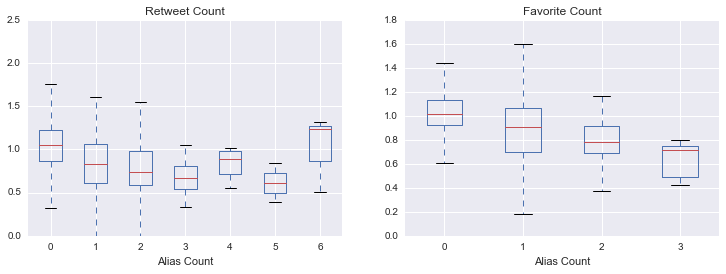

In [174]:
fig, axs = plt.subplots(1,2,figsize=(12,4))

p = df[df['aliastag_count']!=7].boxplot(column=['retweet_count_detrend_weekdayhour'], by=['aliastag_count'], ax=axs[0])
p.set_xlabel("Alias Count")
p.get_figure().suptitle("")
p.set_title('Retweet Count')

p = df[(df['retweet']=='No')&(df['aliastag_count']!=4)].boxplot(column=['favorite_count_detrend_weekdayhour'], by=['aliastag_count'], ax=axs[1])
p.set_xlabel("Alias Count")
p.get_figure().suptitle("")
p.set_title('Favorite Count')
p.get_figure().savefig("alias_box.png")

In [172]:
coefficient, p_val = stats.pearsonr(df[df['aliastag_count']!=7]['retweet_count_detrend_weekdayhour'],
                                    df[df['aliastag_count']!=7]['aliastag_count'])
pearson_retweet = ["Retweet", 'Pearson', coefficient, p_val]
coefficient, p_val = stats.pearsonr(df[(df['retweet']=='No')&(df['aliastag_count']!=4)]['favorite_count_detrend_weekdayhour'],
                                    df[(df['retweet']=='No')&(df['aliastag_count']!=4)]['aliastag_count'])
pearson_favorite = ["Favorite", 'Pearson', coefficient, p_val]

coefficient, p_val = stats.spearmanr(df[df['aliastag_count']!=7]['retweet_count_detrend_weekdayhour'],
                                     df[df['aliastag_count']!=7]['aliastag_count'])
spearman_retweet = ["Retweet", 'Spearman', coefficient, p_val]
coefficient, p_val = stats.spearmanr(df[(df['retweet']=='No')&(df['aliastag_count']!=4)]['favorite_count_detrend_weekdayhour'],
                                    df[(df['retweet']=='No')&(df['aliastag_count']!=4)]['aliastag_count'])
spearman_favorite = ["Favorite", 'Spearman', coefficient, p_val]

coefficient, p_val = stats.kendalltau(df[df['aliastag_count']!=7]['retweet_count_detrend_weekdayhour'],
                                      df[df['aliastag_count']!=7]['aliastag_count'])
kendall_retweet = ["Retweet", 'Kendall', coefficient, p_val]
coefficient, p_val = stats.kendalltau(df[(df['retweet']=='No')&(df['aliastag_count']!=4)]['favorite_count_detrend_weekdayhour'],
                                    df[(df['retweet']=='No')&(df['aliastag_count']!=4)]['aliastag_count'])
kendall_favorite = ["Favorite", 'Kendall', coefficient, p_val]

pd.DataFrame([pearson_retweet,spearman_retweet,kendall_retweet,
              pearson_favorite,spearman_favorite,kendall_favorite
             ],columns=['Dependent Variable','Correlation Test','Coefficient','p-value'])

,Dependent Variable,Correlation Test,Coefficient,p-value
0,Retweet,Pearson,-0.262779,2.272413e-70
1,Retweet,Spearman,-0.278167,5.734551e-79
2,Retweet,Kendall,-0.223161,4.251551e-109
3,Favorite,Pearson,-0.302978,4.905740e-70
4,Favorite,Spearman,-0.219925,6.356434e-37
5,Favorite,Kendall,-0.178131,2.189598e-52


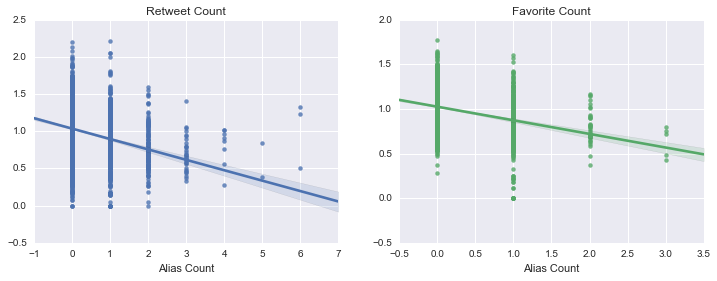

In [176]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
p = sns.regplot(x="aliastag_count", y="retweet_count_detrend_weekdayhour", data=df[df['aliastag_count']!=7], ax=axs[0])
p.set_xlabel("Alias Count")
p.set_ylabel("")
p.set_title('Retweet Count')

p = sns.regplot(x="aliastag_count", y="favorite_count_detrend_weekdayhour", data=df[(df['retweet']=='No')&(df['aliastag_count']!=4)], ax=axs[1])
p.set_xlabel("Alias Count")
p.set_ylabel("")
p.set_title('Favorite Count')
p.get_figure().savefig("alias_scatter.png")

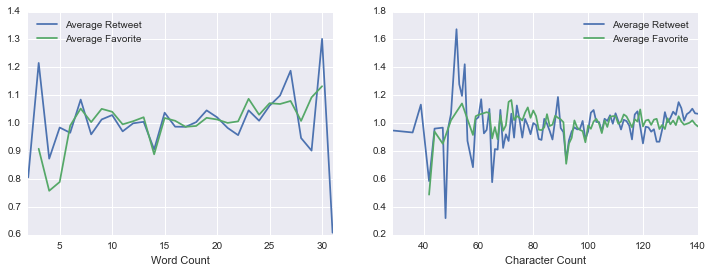

In [185]:
fig, axs = plt.subplots(1,2,figsize=(12,4))

p = df.groupby('word_count')['retweet_count_detrend_weekdayhour'].mean().plot(ax=axs[0])
p = df[df['retweet']=='No'].groupby('word_count')['favorite_count_detrend_weekdayhour'].mean().plot(ax=axs[0])
p.set_xlabel("Word Count")
lines, labels = p.get_legend_handles_labels()
p.legend(lines[:2], ["Average Retweet", "Average Favorite"], loc='best')

p = df.groupby('character_count')['retweet_count_detrend_weekdayhour'].mean().plot(ax=axs[1])
p = df[df['retweet']=='No'].groupby('character_count')['favorite_count_detrend_weekdayhour'].mean().plot(ax=axs[1])
p.set_xlabel("Character Count")
lines, labels = p.get_legend_handles_labels()
p.legend(lines[:2], ["Average Retweet", "Average Favorite"], loc='best')
p.get_figure().savefig("wordchar_line.png")

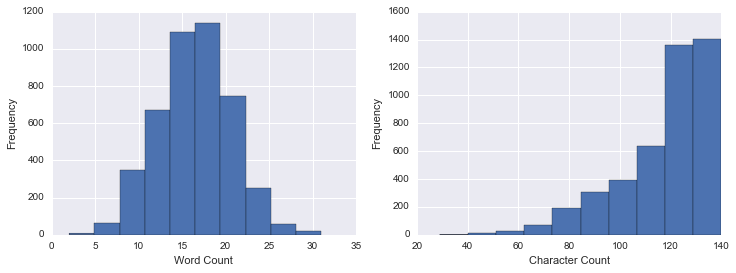

In [186]:
fig, axs = plt.subplots(1,2,figsize=(12,4))

p = df['word_count'].plot.hist(ax=axs[0])
p.set_xlabel("Word Count")

p = df['character_count'].plot.hist(ax=axs[1])
p.set_xlabel("Character Count")
p.get_figure().savefig("wordchar_histogram.png")

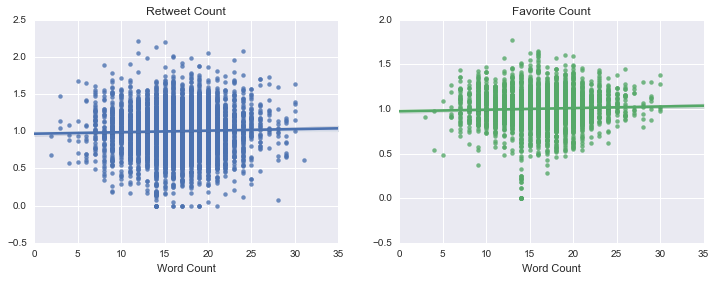

In [197]:
fig, axs = plt.subplots(1,2,figsize=(12,4))

p = sns.regplot(x="word_count", y="retweet_count_detrend_weekdayhour", data=df, ax=axs[0])
p.set_xlabel("Word Count")
p.set_ylabel("")
p.set_title('Retweet Count')

p = sns.regplot(x="word_count", y="favorite_count_detrend_weekdayhour", data=df[df['retweet']=='No'], ax=axs[1])
p.set_xlabel("Word Count")
p.set_ylabel("")
p.set_title('Favorite Count')
p.get_figure().savefig("word_scatter.png")

In [178]:
coefficient, p_val = stats.pearsonr(df['retweet_count_detrend_weekdayhour'],
                                    df['word_count'])
pearson_retweet = ["Retweet", 'Pearson', coefficient, p_val]
coefficient, p_val = stats.pearsonr(df[df['retweet']=='No']['favorite_count_detrend_weekdayhour'],
                                    df[df['retweet']=='No']['word_count'])
pearson_favorite = ["Favorite", 'Pearson', coefficient, p_val]

coefficient, p_val = stats.spearmanr(df['retweet_count_detrend_weekdayhour'],
                                     df['word_count'])
spearman_retweet = ["Retweet", 'Spearman', coefficient, p_val]
coefficient, p_val = stats.spearmanr(df[df['retweet']=='No']['favorite_count_detrend_weekdayhour'],
                                    df[df['retweet']=='No']['word_count'])
spearman_favorite = ["Favorite", 'Spearman', coefficient, p_val]

coefficient, p_val = stats.kendalltau(df['retweet_count_detrend_weekdayhour'],
                                      df['word_count'])
kendall_retweet = ["Retweet", 'Kendall', coefficient, p_val]
coefficient, p_val = stats.kendalltau(df[df['retweet']=='No']['favorite_count_detrend_weekdayhour'],
                                    df[df['retweet']=='No']['word_count'])
kendall_favorite = ["Favorite", 'Kendall', coefficient, p_val]

pd.DataFrame([pearson_retweet,spearman_retweet,kendall_retweet,
              pearson_favorite,spearman_favorite,kendall_favorite
             ],columns=['Dependent Variable','Correlation Test','Coefficient','p-value'])

,Dependent Variable,Correlation Test,Coefficient,p-value
0,Retweet,Pearson,0.028628,0.057613
1,Retweet,Spearman,0.028317,0.060385
2,Retweet,Kendall,0.019345,0.054381
3,Favorite,Pearson,0.037996,0.030206
4,Favorite,Spearman,0.029636,0.090975
5,Favorite,Kendall,0.020036,0.086620


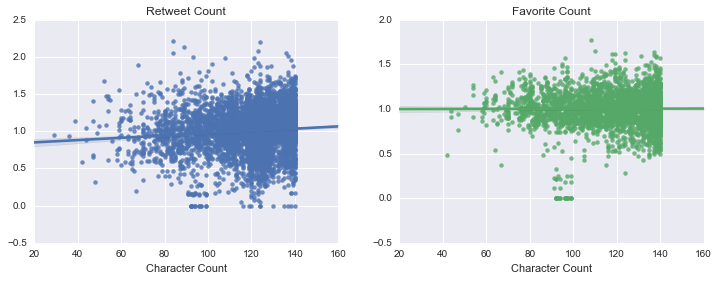

In [198]:
fig, axs = plt.subplots(1,2,figsize=(12,4))

p = sns.regplot(x="character_count", y="retweet_count_detrend_weekdayhour", data=df, ax=axs[0])
p.set_xlabel("Character Count")
p.set_ylabel("")
p.set_title('Retweet Count')

p = sns.regplot(x="character_count", y="favorite_count_detrend_weekdayhour", data=df[df['retweet']=='No'], ax=axs[1])
p.set_xlabel("Character Count")
p.set_ylabel("")
p.set_title('Favorite Count')
p.get_figure().savefig("char_scatter.png")

In [199]:
coefficient, p_val = stats.pearsonr(df['retweet_count_detrend_weekdayhour'],
                                    df['character_count'])
pearson_retweet = ["Retweet", 'Pearson', coefficient, p_val]
coefficient, p_val = stats.pearsonr(df[df['retweet']=='No']['favorite_count_detrend_weekdayhour'],
                                    df[df['retweet']=='No']['character_count'])
pearson_favorite = ["Favorite", 'Pearson', coefficient, p_val]

coefficient, p_val = stats.spearmanr(df['retweet_count_detrend_weekdayhour'],
                                     df['character_count'])
spearman_retweet = ["Retweet", 'Spearman', coefficient, p_val]
coefficient, p_val = stats.spearmanr(df[df['retweet']=='No']['favorite_count_detrend_weekdayhour'],
                                    df[df['retweet']=='No']['character_count'])
spearman_favorite = ["Favorite", 'Spearman', coefficient, p_val]

coefficient, p_val = stats.kendalltau(df['retweet_count_detrend_weekdayhour'],
                                      df['character_count'])
kendall_retweet = ["Retweet", 'Kendall', coefficient, p_val]
coefficient, p_val = stats.kendalltau(df[df['retweet']=='No']['favorite_count_detrend_weekdayhour'],
                                    df[df['retweet']=='No']['character_count'])
kendall_favorite = ["Favorite", 'Kendall', coefficient, p_val]

pd.DataFrame([pearson_retweet,spearman_retweet,kendall_retweet,
              pearson_favorite,spearman_favorite,kendall_favorite
             ],columns=['Dependent Variable','Correlation Test','Coefficient','p-value'])

,Dependent Variable,Correlation Test,Coefficient,p-value
0,Retweet,Pearson,0.091420,1.244406e-09
1,Retweet,Spearman,0.116822,7.685339e-15
2,Retweet,Kendall,0.078241,7.201116e-15
3,Favorite,Pearson,0.003807,8.281378e-01
4,Favorite,Spearman,-0.026104,1.365509e-01
5,Favorite,Kendall,-0.017395,1.368464e-01


In [ ]:
p_val

In [ ]:
df.dtypes

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, #max_features=n_features,
                                   stop_words='english')

In [ ]:
tfidf = tfidf_vectorizer.fit_transform(df['text'])

In [ ]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, #max_features=n_features,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(df['text'])

In [ ]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [ ]:
lda = LatentDirichletAllocation(n_topics=50, max_iter=5,
                                learning_method='online', learning_offset=50.,
                                random_state=0)

In [ ]:
lda.fit(tf)

In [ ]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [ ]:
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, 100)